## Import packages

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import linearmodels as lm

## Import data

This imports updated data directly from [Ken French's data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). More specifically, I import market, size, value, and momentum factors, together with returns on 49 industry portfolios.

#### Daily Data

In [2]:
# Download Carhartt 4 Factors
factors_daily = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start='1/1/1900')[0]
mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='1/1/1900')[0]
factors_daily = factors_daily.join(mom)
factors_daily = factors_daily[['Mkt-RF','SMB','HML','Mom   ','RF']]
    
# Download Fama/French 49 Industries
industries_daily = web.DataReader("49_Industry_Portfolios_Daily", "famafrench", start='1/1/1900')[0]
industries_daily[(industries_daily <= -99.99) | (industries_daily == -999)] = np.nan #set missing data to NaN
industries_daily = industries_daily.subtract(factors_daily['RF'], axis=0) #transform into excess returns

#### Monthly Data

In [3]:
# Download Carhartt 4 Factors
factors_monthly = web.DataReader("F-F_Research_Data_Factors", "famafrench", start='1/1/1900')[0]
mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1/1/1900')[0]
factors_monthly = factors_monthly.join(mom)
factors_monthly = factors_monthly[['Mkt-RF','SMB','HML','Mom   ','RF']]
factors_monthly.index = factors_monthly.index.to_timestamp()
    
# Download Fama/French 49 Industries
industries_monthly = web.DataReader("49_Industry_Portfolios", "famafrench", start='1/1/1900')[0]
industries_monthly[(industries_monthly <= -99.99) | (industries_monthly == -999)] = np.nan #set missing data to NaN
industries_monthly.index = industries_monthly.index.to_timestamp()
industries_monthly = industries_monthly.subtract(factors_monthly['RF'], axis=0) #transform into excess returns

#### FRED Recession indicators

In [375]:
USREC_monthly = web.DataReader('USREC', 'fred',start = industries_monthly.index[0], end=industries_monthly.index[-1])

In [374]:
USREC_daily = pd.DataFrame(index=industries_daily.index.to_period('M'))
temp = USREC_monthly
temp.index = temp.index.to_period('M')
USREC_daily = USREC_daily.join(USREC_monthly)
USREC_daily.index = industries_daily.index

#### Select

In [129]:
industries = industries_daily
factors = factors_daily
USREC = USREC_daily

## Data description

This section serves to carry out basic sanity checks on the data to ensure everything has been imported correctly.

In [130]:
#factors.join(industries).describe()

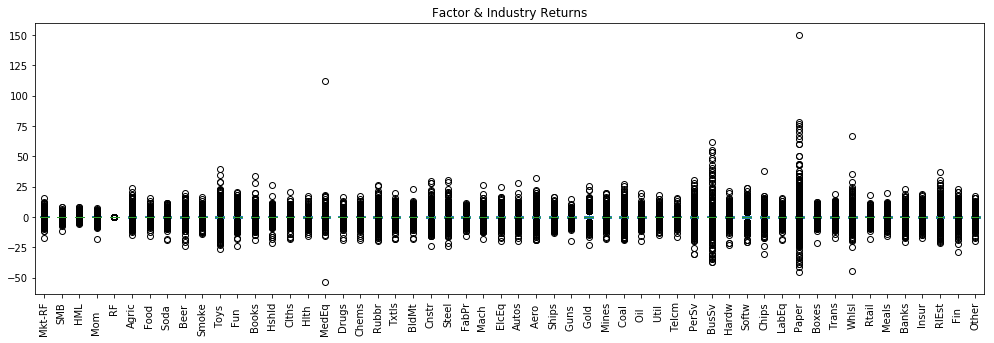

In [131]:
factors.join(industries).plot.box(title='Factor & Industry Returns', figsize=(17,5), rot=90)
plt.show()

## Markov switching models

For each asset $i$, asset returns $r^i_t$ are specified to follow a two state Markov regime switching process with state-dependent intercept $\alpha^i_{S_t}$ and state-dependent market beta $\beta^i_{S_t}$. More formally:

\begin{equation*}
   r^i_t = \alpha^i_{S_t} + r_t^M \beta^i_{S_t} + \varepsilon^i_{t},  \quad\quad   \varepsilon_{t} \sim N(0,\sigma^2_i)
\end{equation*}

where states $S_t \in \{0,1\}$ and the regimes switch according to the following transition matrix:

\begin{equation*}
    P(S^i_t = s^i_t \, | \, S^i_{t-1} = s^i_{t-1}) = 
    \begin{bmatrix}
        p^i_{00}& p^i_{10}\\
        1-p^i_{00} & 1-p^i_{10}\\
    \end{bmatrix}
\end{equation*}

The parameters $p^i_{00}, p^i_{10}, \alpha^i_0, \alpha^i_1, \beta^i_0, \beta^i_1, σ^2_i$ are estimated by maximum likelihood.

Note that different specifications with state-dependent variances $\sigma_{i,S_t}^2$ or more independent variables (factors) are possible to specify. However, the estimation becomes increasingly difficult with the number of additional parameters and the algorithm does not reliably converge in many cases. For this reason, I stick to the specification above for now.

<!---
The likelihood function for this specific problem is:

\begin{equation*}
    L(r^i|\theta,r^M) = \prod^T_{t=1} \Big( \sum^1_{s_t=0} \phi\big(r^i_t|\alpha_{S_t}+ \beta_{S_t} r^M_t, \sigma^2\big)* Pr\big[S_t=s_t|\theta\big] \Big)
\end{equation*}
-->

In [132]:
# set up output frame
regime = pd.DataFrame(columns = industries.columns, index = industries.index)

# load independent variable
x = factors.iloc[:, 0]

for iAsset in range(0,len(industries.columns)):
    # extract industry data
    y = industries.iloc[:, iAsset]
    
    # estimate model
    model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=x, switching_variance=False, switching_trend=True, missing='drop').fit()
    
    # save estimates
    regime.iloc[:,iAsset] = model.smoothed_marginal_probabilities[0]
    
    # clear temporary variables
    del y, model
    
    # print progress
    if (iAsset+1)%1 is 0:
        print('finished',iAsset+1,'out of',len(industries.columns))
    
del x

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 1 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 2 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 3 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 4 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 5 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 6 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 7 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 8 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 9 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 10 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 11 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1757: RuntimeWarning: divide by zero encountered in log
  self.llf_obs = np.log(self.joint_likelihoods)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaco

finished 12 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 13 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 14 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 15 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 16 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 17 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 18 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 19 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 20 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 21 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 22 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 23 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 24 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 25 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 26 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 27 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 28 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 29 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 30 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 31 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 32 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 33 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1144: RuntimeWarning: invalid value encountered in log
  return np.log(results[5])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 34 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 35 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 36 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 37 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 38 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\regime_switching\markov_switching.py:1757: RuntimeWarning: divide by zero encountered in log
  self.llf_obs = np.log(self.joint_likelihoods)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\ProgramData\Anaco

finished 39 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 40 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 41 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


finished 42 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 43 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 44 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 45 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 46 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 47 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 48 out of 49


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


finished 49 out of 49


In [58]:
#regime.plot(title='Probabilities of being in high ambiguity regime', figsize=(17,6), legend=False)
#plt.show()

## Ambiguity measurement

If we assume that the agents' perceived ambiguity is related to the uncertainty of being in either of the two regimes, we can construct a measure of ambiguity based on the estimated marginal probabilities of being in either of the states. In this framework, maximum ambiguity is reached when the two states are equally likely (p=0.5). On the other hand there is no ambiguity if all the probability mass is on one state (either p=0 or p=1). Therefore, the measure is constructed as follows:

\begin{equation*}
    ambiguity^i_t = 1-4*\big(Pr [S^i_t = 0]-0.5\big)^2
\end{equation*}

This measure takes a value of one if both states are equally likely (maximum uncertainty), and zero if there is no uncertainty about what state the process is currently in.

Note that the current estimation technique is forward looking as the regime switching models are estimated using the full sample. This could be avoided by using rolling/expanding windows when estimating the models, which will be computationally challenging.

In [137]:
ambig = 1-4*(regime-0.5)**2

In [138]:
ambig.describe()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,2.439100e+04,24391.000000,1.397100e+04,2.439100e+04,2.439100e+04,2.439100e+04,2.439100e+04,24391.000000,2.439100e+04,24391.000000,...,2.439100e+04,2.439100e+04,0.0,24391.000000,24391.000000,2.439100e+04,2.439100e+04,2.439100e+04,2.439100e+04,2.439100e+04
mean,3.713011e-01,0.309481,2.697338e-01,3.002482e-01,2.444516e-01,3.257484e-03,4.664947e-01,0.509032,2.761834e-01,0.283868,...,6.421162e-01,3.212257e-01,NaN,0.303504,0.373995,3.360775e-03,8.668854e-03,4.410935e-03,2.620106e-01,6.375801e-01
std,2.351588e-01,0.338181,2.988066e-01,3.107606e-01,3.245856e-01,4.603071e-02,2.392235e-01,0.349411,3.174717e-01,0.324379,...,3.177818e-01,3.352309e-01,NaN,0.317243,0.331732,4.610188e-02,7.367450e-02,5.251994e-02,2.876158e-01,3.256822e-01
min,-2.930989e-14,0.000000,1.598721e-14,-8.881784e-15,-5.506706e-14,-4.263256e-14,-4.263256e-14,0.000000,-6.217249e-15,0.000000,...,-6.750156e-14,-7.904788e-14,NaN,0.000000,0.000000,-9.414691e-14,-8.881784e-14,-3.286260e-14,-2.753353e-14,-1.865175e-14
25%,2.085812e-01,0.025961,2.947751e-02,5.085511e-02,1.258619e-02,4.430967e-11,3.060095e-01,0.164851,2.593392e-02,0.020351,...,3.880869e-01,3.499485e-02,NaN,0.048078,0.080499,6.023715e-11,1.750649e-07,1.043139e-09,5.188484e-02,3.747498e-01
50%,3.413271e-01,0.146017,1.338363e-01,1.688891e-01,6.890303e-02,5.102647e-10,4.560460e-01,0.515325,1.236240e-01,0.126975,...,7.329046e-01,1.722530e-01,NaN,0.165423,0.267854,9.573116e-10,1.561533e-06,1.454741e-08,1.428015e-01,7.267382e-01
75%,4.848547e-01,0.580287,4.366138e-01,4.789204e-01,3.899474e-01,6.380706e-09,6.070084e-01,0.857098,4.564845e-01,0.501220,...,9.312128e-01,5.779144e-01,NaN,0.502034,0.638600,1.640162e-08,1.338804e-05,1.941754e-07,3.554671e-01,9.391787e-01
max,9.999999e-01,1.000000,1.000000e+00,9.999999e-01,1.000000e+00,9.999385e-01,9.999999e-01,1.000000,9.999998e-01,1.000000,...,1.000000e+00,1.000000e+00,NaN,1.000000,1.000000,9.999940e-01,9.999998e-01,9.999994e-01,1.000000e+00,1.000000e+00


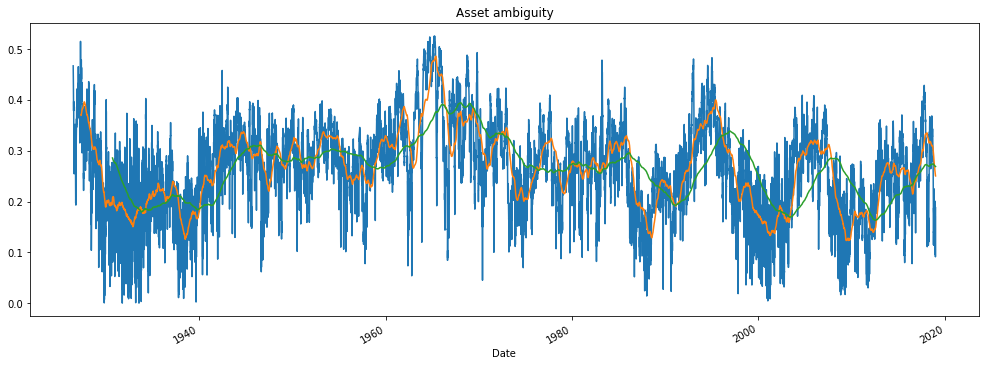

In [139]:
ambig.iloc[:,:].mean(axis=1).plot(title='Asset ambiguity', figsize=(17,6), legend=False)
ambig.iloc[:,:].mean(axis=1).rolling(250).mean().plot(title='Asset ambiguity', figsize=(17,6), legend=False)
ambig.iloc[:,:].mean(axis=1).rolling(1250).mean().plot(title='Asset ambiguity', figsize=(17,6), legend=False)
plt.show()

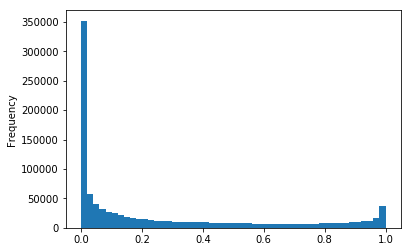

In [140]:
ambig.stack().plot.hist(50)
plt.show()

In [141]:
#s1 = industries.mean(axis=1).rolling(1000).mean().plot(title='Rolling 12-Month return vs. ambiguity',figsize=(17,6))
#s2 = ambig.mean(axis=1).rolling(1000).mean().pct_change().mul(50).plot(figsize=(17,6))

In [188]:
Y = industries.sub(industries.mean(axis=1), axis=0).div(industries.std(axis=1), axis=0).rolling(1).mean()
X = ambig.diff().sub(ambig.mean(axis=1), axis=0).div(ambig.std(axis=1), axis=0).rolling(1).mean().shift(1)
Y.columns = np.arange(49) #industries.columns
X.columns = np.arange(49) #industries.columns
Y = Y.stack(dropna=False)
X = X.stack(dropna=False)
X = sm.add_constant(X)
X.columns = ['constant','ambiguity']

In [189]:
mod = lm.PooledOLS(Y,X).fit(cov_type='kernel') # alternatively: sm.OLS(Y,X, missing='drop').fit()
mod

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,0,R-squared:,6.715e-06
Estimator:,PooledOLS,R-squared (Between):,1.514e-05
No. Observations:,997949,R-squared (Within):,6.73e-06
Date:,"Fri, Jan 25 2019",R-squared (Overall):,6.715e-06
Time:,13:50:20,Log-likelihood,-1.409e+06
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,6.7012
Entities:,24389,P-value,0.0096
Avg Obs:,40.918,Distribution:,"F(1,997947)"
Min Obs:,36.000,,
Max Obs:,45.000,F-statistic (robust):,2.7932


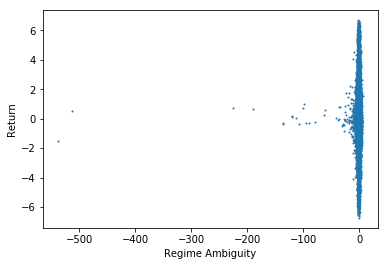

In [372]:
plt.scatter(X['ambiguity'],Y,1) 
plt.xlabel("Regime Ambiguity")
plt.ylabel("Return")
plt.show()

In [160]:
y = industries.iloc[:-1,:].mean()
x = sm.add_constant(ambig.mean())

In [161]:
sm.OLS(y,x, missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.122
Date:                Fri, 25 Jan 2019   Prob (F-statistic):              0.295
Time:                        13:45:05   Log-Likelihood:                 164.80
No. Observations:                  45   AIC:                            -325.6
Df Residuals:                      43   BIC:                            -322.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0336      0.002     21.740      0.000       0.030       0.037
0             -0.0052      0.005     -1.059      0.295      -0.015       0.005
==============================================================================
Omnibus:                        0.565   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.183
Skew:                          -0.147   Prob(JB):                        0.912
Kurtosis:                       3.106   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

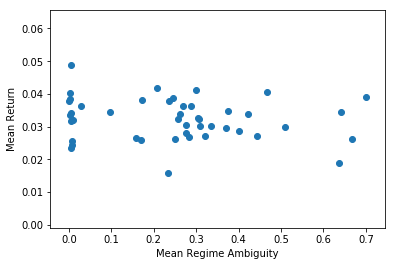

In [147]:
plt.scatter(x.iloc[:,1],y) 
plt.xlabel("Mean Regime Ambiguity")
plt.ylabel("Mean Return")
plt.show()

## Sorted Portfolios

This sorts assets into portfolios and returns average returns. 1 is the low ambiguity portfolio and 5 is the high ambiguity portfolio.

In [190]:
def sort_portfolios(returns, ranking_variable, n_portfolios, lags):
    sorting_variable = ranking_variable.shift(lags)
    include = ~returns.isna() & ~sorting_variable.isna()
    n_period = include.sum(axis=1)
    [t,n] = returns.shape
    cutoff_ranks = np.dot(n_period.values.reshape(t,1)/n_portfolios,np.arange(n_portfolios+1).reshape(1,n_portfolios+1)).round()
    asset_ranks = sorting_variable.rank(axis=1)
    portfolio_returns = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    portfolio_assets = pd.DataFrame(index=returns.index,columns=range(1,n_portfolios+1))
    for i_portfolio in range(0,n_portfolios):
        lower = cutoff_ranks[:,i_portfolio].reshape(t,1).repeat(n, axis=1)
        upper = cutoff_ranks[:,i_portfolio+1].reshape(t,1).repeat(n, axis=1)
        portfolio_returns[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].mean(axis=1)
        portfolio_assets[i_portfolio+1] = returns[(asset_ranks>lower) & (asset_ranks<=upper)].count(axis=1)
    return portfolio_returns

In [215]:
val_ambig = ambig[ambig>0.0001]
ambig_portfolios = sort_portfolios(industries,val_ambig,5,1)
ambig_means = ambig_portfolios.mean()
ambig_means

1    0.023978
2    0.027271
3    0.023423
4    0.032228
5    0.038596
dtype: float64

In [216]:
(ambig_means[5]-ambig_means[1])*250

3.6543631106138235

## Historical measure

The measure I propose follows the same simple idea as is used to estimate risk: Variance (or any other measure of risk) is estimated from a sample of return observations. Instead of a sample of individual returns, we now observe a sample of return distributions. In order to estimate the variability of the distributions we have to quantify the distance between these empirical distributions. I suggest to use the following:

\begin{equation*}
    Dist(A,B) = \frac{\int_{min(A\bigcup B)}^{max(A\bigcup B)}\Big(F_A(x)-F_A(x)\Big)dx}{max\big(A\bigcup B\big)-min\big(A\bigcup B\big)}
\end{equation*}

Essentially, the measure calculates the integral between the empirical cumulative distribution function $F_X$ of sample $X$ and standardises it by the dispersion of observations in both samples.

In [8]:
def calculate_nonequivalence(sample1,sample2):
    sample1 = sample1.dropna()
    sample2 = sample2.dropna()
    if len(sample1)==0 or len(sample2)==0:
        return np.nan
    else:
        data1 = pd.DataFrame(index=sample1.index,columns=['x','sample'])
        data2 = pd.DataFrame(index=sample2.index,columns=['x','sample'])
        data1['x'] = sample1
        data2['x'] = sample2
        data1['sample'] = 1
        data2['sample'] = 2
        increment1 = 1/len(sample1)
        increment2 = 1/len(sample2)
        frame = pd.concat([data1,data2]).sort_values('x')
        frame['y1'] = (frame['sample']==1).cumsum()*increment1
        frame['y2'] = (frame['sample']==2).cumsum()*increment2
        frame['xdelta'] = frame['x'].diff()
        frame['ydiff'] = (frame['y1']-frame['y2']).abs()
        surface = ((frame['xdelta'].iloc[1:].values)*(frame['ydiff'].iloc[:-1].values)).sum()
        return_range = frame['x'][-1]-frame['x'][0]
        return surface/return_range
    
def calculate_distributional_variation(data, bins):
    samples = bins.unique()
    cross_store = pd.DataFrame(index=samples, columns=samples)
    for i_bin in samples:
        sample1 = data.iloc[bins==i_bin]
        for j_bin in samples:
            if j_bin>i_bin:
                sample2 = data.iloc[bins==j_bin]
                cross_store.loc[i_bin,j_bin] = calculate_nonequivalence(sample1,sample2)
    return cross_store.stack().mean()

def calculate_dist_dev(data,bins):
    samples = bins.unique()
    cross_store = pd.Series(index=samples)
    data_norm = data.sub(data.mean()).div(data.std())
    for i_bin in samples:
        sample = data.iloc[bins==i_bin]
        sample_norm = sample.sub(sample.mean()).div(sample.std())
        cross_store.loc[i_bin] = calculate_nonequivalence(data_norm,sample_norm)
    return cross_store.mean()

In [6]:
window = 60
yearmonths = industries_daily.index.to_period('M').unique()
uncertainty = pd.DataFrame(index=yearmonths, columns=industries_daily.columns)
for i_yearmonth in yearmonths[window:]:
    days = industries_daily.index[(industries_daily.index.to_period('M')<i_yearmonth)&(industries_daily.index.to_period('M')>=i_yearmonth-window)]
    bins = days.to_period('M')
    for i_asset in industries_daily.columns:
        data = industries_daily.loc[days,i_asset]
        #uncertainty.loc[i_yearmonth,i_asset] = calculate_distributional_variation(data, bins)
        uncertainty.loc[i_yearmonth,i_asset] = calculate_dist_dev(data, bins)
    print('period',i_yearmonth)
uncertainty.index = uncertainty.index.to_timestamp()

#uncertainty.to_csv('unc.csv')

period 1931-07
period 1931-08
period 1931-09
period 1931-10
period 1931-11
period 1931-12
period 1932-01
period 1932-02
period 1932-03
period 1932-04
period 1932-05
period 1932-06
period 1932-07
period 1932-08
period 1932-09
period 1932-10
period 1932-11
period 1932-12
period 1933-01
period 1933-02
period 1933-03
period 1933-04
period 1933-05
period 1933-06
period 1933-07
period 1933-08
period 1933-09
period 1933-10
period 1933-11
period 1933-12
period 1934-01
period 1934-02
period 1934-03
period 1934-04
period 1934-05
period 1934-06
period 1934-07
period 1934-08
period 1934-09
period 1934-10
period 1934-11
period 1934-12
period 1935-01
period 1935-02
period 1935-03
period 1935-04
period 1935-05
period 1935-06
period 1935-07
period 1935-08
period 1935-09
period 1935-10
period 1935-11
period 1935-12
period 1936-01
period 1936-02
period 1936-03
period 1936-04
period 1936-05
period 1936-06
period 1936-07
period 1936-08
period 1936-09
period 1936-10
period 1936-11
period 1936-12
period 193

period 1977-02
period 1977-03
period 1977-04
period 1977-05
period 1977-06
period 1977-07
period 1977-08
period 1977-09
period 1977-10
period 1977-11
period 1977-12
period 1978-01
period 1978-02
period 1978-03
period 1978-04
period 1978-05
period 1978-06
period 1978-07
period 1978-08
period 1978-09
period 1978-10
period 1978-11
period 1978-12
period 1979-01
period 1979-02
period 1979-03
period 1979-04
period 1979-05
period 1979-06
period 1979-07
period 1979-08
period 1979-09
period 1979-10
period 1979-11
period 1979-12
period 1980-01
period 1980-02
period 1980-03
period 1980-04
period 1980-05
period 1980-06
period 1980-07
period 1980-08
period 1980-09
period 1980-10
period 1980-11
period 1980-12
period 1981-01
period 1981-02
period 1981-03
period 1981-04
period 1981-05
period 1981-06
period 1981-07
period 1981-08
period 1981-09
period 1981-10
period 1981-11
period 1981-12
period 1982-01
period 1982-02
period 1982-03
period 1982-04
period 1982-05
period 1982-06
period 1982-07
period 198

In [8]:
#uncertainty.to_csv('unc_standard.csv')

In [161]:
uncertainty = pd.read_csv('unc_standard.csv',index_col='Date')
unc = pd.read_csv('unc.csv',index_col='Date')

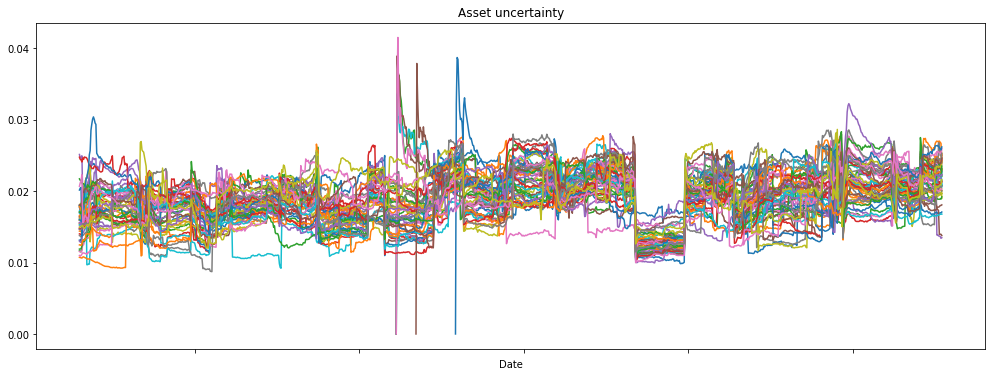

In [159]:
uncertainty.iloc[:,:].plot(title='Asset uncertainty', figsize=(17,6), legend=False)

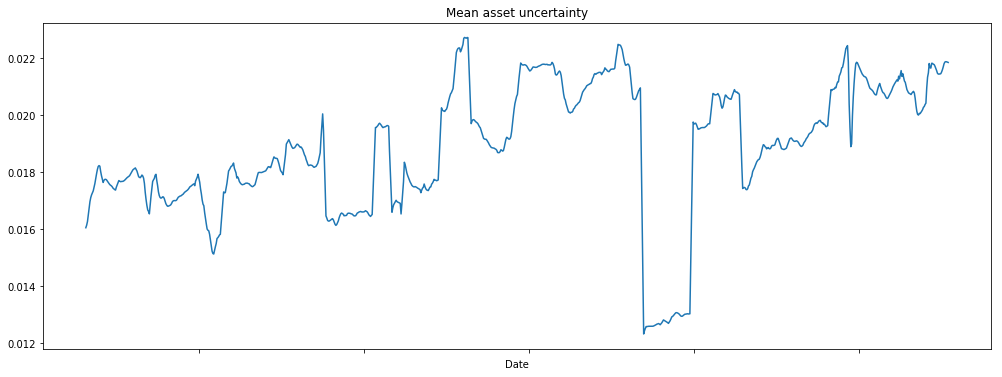

In [156]:
uncertainty.mean(axis=1).rolling(4).mean().plot(title='Mean asset uncertainty', figsize=(17,6), legend=False)
#industries_monthly.iloc[:-1].mean(axis=1).div(1000).plot()

In [82]:
X = uncertainty.mean(axis=1).rolling(1).mean().shift(12)
Y = industries_monthly.iloc[:-1].mean(axis=1).rolling(12).mean()
X = sm.add_constant(X)
sm.OLS(Y,X, missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.029
Date:                Thu, 24 Jan 2019   Prob (F-statistic):            0.00469
Time:                        15:49:54   Log-Likelihood:                -1913.0
No. Observations:                1037   AIC:                             3830.
Df Residuals:                    1035   BIC:                             3840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8795      0.390      4.823      0.000       1.115       2.644
0            -58.2702     20.565     -2.833      0.005     -98.624     -17.917
==============================================================================
Omnibus:                       96.551   Durbin-Watson:                   0.163
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              527.640
Skew:                           0.202   Prob(JB):                    2.66e-115
Kurtosis:                       6.471   Cond. No.                         432.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
Y = industries_monthly.sub(industries_monthly.mean(axis=1), axis=0).div(industries_monthly.std(axis=1), axis=0).iloc[:-1,:].rolling(1).mean()
X = uncertainty.rolling(1).mean().shift(1).sub(uncertainty.mean(axis=1), axis=0).div(uncertainty.std(axis=1), axis=0)
Y.columns = np.arange(49)
X.columns = np.arange(49)
Y = Y.stack(dropna=False)
X = X.stack(dropna=False)
X = sm.add_constant(X)
X.columns = ['constant','uncertainty']

In [153]:
mod = lm.PooledOLS(Y,X).fit(cov_type='kernel') # alternatively: sm.OLS(Y,X, missing='drop').fit()
mod

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,0,R-squared:,2.472e-05
Estimator:,PooledOLS,R-squared (Between):,-0.0013
No. Observations:,48946,R-squared (Within):,3.182e-05
Date:,"Thu, Jan 24 2019",R-squared (Overall):,2.472e-05
Time:,19:02:02,Log-likelihood,-6.907e+04
Cov. Estimator:,Driscoll-Kraay,,
,,F-statistic:,1.2101
Entities:,1048,P-value,0.2713
Avg Obs:,46.704,Distribution:,"F(1,48944)"
Min Obs:,43.000,,
Max Obs:,49.000,F-statistic (robust):,0.9342


In [72]:
unc_portfolios = sort_portfolios(industries_monthly.iloc[:-1,:],uncertainty,5,1)
unc_means = unc_portfolios.mean()
unc_means
(unc_means[5]-unc_means[1])*12

1.4438206106870273

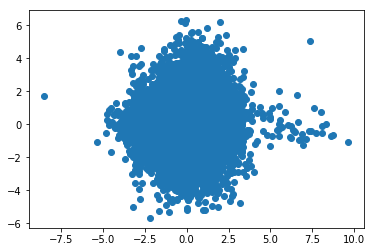

In [160]:
plt.scatter(X['uncertainty'].values,Y.values)